# 03.3 Continuous-Time Martingales
<h3><span style="color:#800000;"><strong>Authored by:</strong> <em>Alexandre Mathias DONNAT, Sr</em></span></h3>

**Goal of this notebook**
- Introduce martingales in continuous time with respect to a filtration.
- Give key examples built from Brownian motion:
- $W_t$, $W_t^2 - t$, and the exponential martingale.
- State a simple version of the optional stopping theorem for bounded stopping times and illustrate it numerically.
- Show a typical incorrect use with an unbounded hitting time, to understand the role of assumptions.
- State Doob's maximal inequality (without proof) as a structural tool for later notebooks.

**This notebook**

Connects Brownian motion and martingales in continuous time, and prepares the ground for the Snell envelope, Itô calculus and SDEs.


## 1. From discrete-time to continuous-time martingales

In discrete time, a process $(M_n)_{n \in \mathbb{N}}$ adapted to $(\mathcal{F}_n)$ is a martingale if

- $\mathbb{E}[|M_n|] < \infty$ for all $n$,
- $\mathbb{E}[M_{n+1} \mid \mathcal{F}_n] = M_n$ almost surely.

Supermartingales and submartingales are obtained by replacing equality with $\leq$ or $\geq$.

In continuous time, the definition is similar, with time index $t \in [0, \infty)$.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

rng = np.random.default_rng(123)

plt.rcParams["figure.figsize"] = (8, 4)
plt.rcParams["axes.grid"] = True

def simulate_brownian_paths(T=1.0, n_steps=1000, n_paths=1, rng=None):
    """
    Simulate n_paths standard Brownian motions on [0,T]
    using exact Gaussian increments.
    Returns t_grid (shape (n_steps+1,)) and W (shape (n_paths, n_steps+1)).
    """
    if rng is None:
        rng = np.random.default_rng()
    dt = T / n_steps
    t_grid = np.linspace(0.0, T, n_steps + 1)
    dW = rng.normal(0.0, np.sqrt(dt), size=(n_paths, n_steps))
    W = np.concatenate([np.zeros((n_paths, 1)), np.cumsum(dW, axis=1)], axis=1)
    return t_grid, W

# 1. Martingales in continuous time

Let $(\Omega, \mathcal{F}, (\mathcal{F}_t)_{t \geq 0}, P)$ be a filtered probability space satisfying the usual conditions.

A process $(M_t)_{t \geq 0}$ is a (continuous-time) **martingale** with respect to $(\mathcal{F}_t)$ if:

1. $M_t$ is $\mathcal{F}_t$-measurable for each $t$ (adapted),
2. $\mathbb{E}[|M_t|] < \infty$ for each $t$,
3. for all $0 \leq s \leq t$,
    $$\mathbb{E}[M_t \mid \mathcal{F}_s] = M_s \quad \text{almost surely}.$$

If we replace the equality by $\leq$, we obtain a **supermartingale**; with $\geq$, a **submartingale**.

A martingale represents a "fair game" where the conditional expectation of the future value given the current information equals the current value.


# 2. Brownian martingales: key examples

Throughout this notebook, $(W_t)_{t \geq 0}$ denotes a standard Brownian motion with respect to its natural filtration.

## 2.1 The basic martingale: $W_t$

Using the independent and stationary increments of Brownian motion, one checks that

$$\mathbb{E}[W_t \mid \mathcal{F}_s] = W_s, \quad 0 \leq s \leq t.$$

Thus $(W_t)_{t \geq 0}$ is a continuous-time martingale.

## 2.2 Quadratic martingale: $W_t^2 - t$

A similar computation yields

$$\mathbb{E}[W_t^2 - t \mid \mathcal{F}_s] = W_s^2 - s, \quad 0 \leq s \leq t,$$

which shows that

$$M_t = W_t^2 - t$$

is also a martingale. This comes from the fact that

$$\text{Var}(W_t - W_s) = t - s,$$

and the cross term $\mathbb{E}[W_s(W_t - W_s) \mid \mathcal{F}_s]$ vanishes.

## 2.3 Exponential martingale

For $\sigma \in \mathbb{R}$, the process

$$M_t(\sigma) = \exp\left(\sigma W_t - \frac{1}{2}\sigma^2 t\right)$$

is a positive martingale. A rigorous proof in continuous time uses Itô's formula and will appear in the notebook on Itô calculus. For now, we simply record this as a fundamental example.


## 3. Numerical checks: $W_t$, $W_t^2 - t$, and the exponential martingale

We now fix a time horizon $T$ and several intermediate times, and check numerically that the expectations of these processes remain (approximately) constant.

We expect:

- $\mathbb{E}[W_t] \approx 0$ for all times,$\mathbb{E}[W_t] \approx 0$ for all times,
- $\mathbb{E}[W_t^2 - t] \approx 0$ for all times, $\mathbb{E}[W_t^2 - t] \approx 0$ for all times,
- $\mathbb{E}[M_t(\sigma)] \approx 1$ for all times.$\mathbb{E}[M_t(\sigma)] \approx 1$ for all times.


In [2]:
T = 1.0
n_steps = 1000
n_paths = 50_000

t, W = simulate_brownian_paths(T=T, n_steps=n_steps, n_paths=n_paths, rng=rng)

# times at which we evaluate the martingales
times_idx = [0, 250, 500, 750, 1000]
times = t[times_idx]

# martingale 1: W_t
means_W = [W[:, k].mean() for k in times_idx]

# martingale 2: W_t^2 - t
W2_minus_t = W**2 - t  # broadcasting over t
means_W2_minus_t = [W2_minus_t[:, k].mean() for k in times_idx]

# martingale 3: exponential martingale
sigma = 1.0
M_exp = np.exp(sigma * W - 0.5 * sigma**2 * t)
means_M_exp = [M_exp[:, k].mean() for k in times_idx]

pd.DataFrame({
    "t": times,
    "E[W_t]": means_W,
    "E[W_t^2 - t]": means_W2_minus_t,
    "E[M_t^(sigma)]": means_M_exp
})


,t,E[W_t],E[W_t^2 - t],E[M_t^(sigma)]
0,0.00,0.000000,0.000000,1.000000
1,0.25,0.001504,-0.001103,1.000776
2,0.50,0.002385,-0.000129,1.001576
3,0.75,0.005069,-0.002026,1.002711
4,1.00,0.005281,-0.000609,1.001827


This provides numerical evidence of the martingale property.

## 4. Optional stopping theorem (bounded stopping times)

One of the most important structural results about martingales is the **optional stopping theorem**.

Let $(M_t)_{t \geq 0}$ be a martingale and $\tau$ a stopping time. In full generality, there are several versions with technical conditions. In this notebook we restrict to a simple and useful case.

**Theorem 4.1 (optional stopping, bounded time).**  
Let $(M_t)_{t \geq 0}$ be an integrable martingale with respect to $(\mathcal{F}_t)$.  
Let $\tau$ be a stopping time such that $\tau \leq T$ almost surely for some deterministic $T < \infty$.  
Then

$$\mathbb{E}[M_\tau] = \mathbb{E}[M_0].$$

We approximate $\tau$ by simple stopping times taking values on a discrete grid, apply the discrete-time result, and then pass to the limit using integrability and right-continuity.

In this notebook, we apply the theorem only to Brownian martingales with bounded stopping times (typically truncated hitting times).


## 5. Application: truncated hitting times for Brownian motion

We consider Brownian motion and the first hitting time of a level $a > 0$:

$$T_a = \inf\{t \geq 0 : W_t \geq a\}.$$

This random time is in general unbounded. To apply Theorem 4.1, we introduce a truncated version:

$$\tau_K = T_a \wedge K = \min(T_a, K),$$

which is a bounded stopping time with $\tau_K \leq K$.

For the martingale $M_t = W_t$, the optional stopping theorem then gives

$$\mathbb{E}[W_{\tau_K}] = \mathbb{E}[W_0] = 0.$$

We now check this numerically.


## 5.1 Numerical approximation of $T_a$ and $\tau_K$

We approximate $T_a$ on a discrete grid and then define $\tau_K$ by truncation.


In [ ]:
def simulate_hitting_time_truncated(a=1.0, K=1.0, n_steps=2000, rng=None):
    """
    Simulate one Brownian path on [0,K], approximate the first hitting time
    T_a = inf{t : W_t >= a} on the discrete grid, and return tau_K = min(T_a, K),
    together with W_{tau_K}.
    """
    if rng is None:
        rng = np.random.default_rng()
    t_grid, W_path = simulate_brownian_paths(T=K, n_steps=n_steps, n_paths=1, rng=rng)
    W_path = W_path[0]

    hit_indices = np.where(W_path >= a)[0]
    if hit_indices.size > 0:
        idx_hit = hit_indices[0]
        tau_approx = t_grid[idx_hit]
    else:
        tau_approx = K
        idx_hit = len(t_grid) - 1

    return tau_approx, W_path[idx_hit]

We repeat this many times and compute the empirical average of $W_{\tau_K}$.

We expect $\mathbb{E}[W_{\tau_K}] \approx 0$.


In [5]:
a = 1.0
K = 1.0
n_steps = 2000
n_paths = 20_000

taus = []
values = []

for _ in range(n_paths):
    tau_k, W_tau_k = simulate_hitting_time_truncated(a=a, K=K, n_steps=n_steps, rng=rng)
    taus.append(tau_k)
    values.append(W_tau_k)

taus = np.array(taus)
values = np.array(values)

print(f"Mean of tau_K ≈ {taus.mean():.4f}")
print(f"Mean of W_(tau_K) ≈ {values.mean():.4f} (theoretical: 0)")

Mean of tau_K ≈ 0.8506
Mean of W_(tau_K) ≈ 0.0039 (theoretical: 0)


The results are coherent: the mean of $W_{\tau_K}$ is extremely close to 0, as expected, and the average $\tau_K$ is below 1 because many paths hit the level $a=1$ before time $K$. Small deviations come from grid discretisation and Monte-Carlo noise.


## 5.2 Visualising the distribution of $\tau_K$


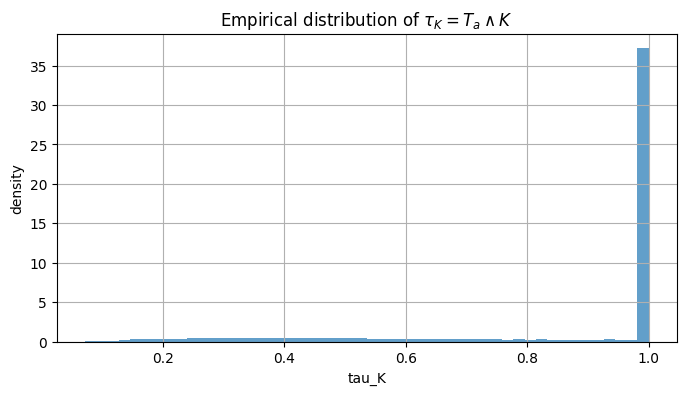

In [6]:
fig, ax = plt.subplots()
ax.hist(taus, bins=50, density=True, alpha=0.7)
ax.set_title(r"Empirical distribution of $\tau_K = T_a \wedge K$")
ax.set_xlabel("tau_K")
ax.set_ylabel("density")
plt.show()

The distribution is dominated by a large spike at $\tau_K = K$, corresponding to paths that never reach the level $a$ before time $K$. Only a small fraction of trajectories hit the barrier earlier, producing the thin spread over $[0,1)$.


## 6. Why the optional stopping theorem fails without truncation

If we try to apply the identity

$$\mathbb{E}[W_{T_a}] = \mathbb{E}[W_0]$$

directly to the unbounded hitting time $T_a$, we obtain

$$\mathbb{E}[W_{T_a}] = \mathbb{E}[a] = a,$$

since $W_{T_a} = a$ almost surely. This would imply $a = 0$, which is a contradiction.

The conclusion is that the assumptions of the optional stopping theorem are not satisfied: in particular, $T_a$ is not bounded, and the moment conditions required by more general versions of the theorem fail.

We can see numerically that the distribution of $T_a$ has heavy tails: many paths hit the level quickly, but some paths take a long time to reach $a$. This is why truncated times $\tau_K = T_a \wedge K$ are used in practice.


# 7. Doob's maximal inequality (statement only)

For $L^2$-martingales, Doob's maximal inequality controls the size of the running maximum in terms of the terminal value.

Let $(M_t)_{0 \leq t \leq T}$ be a square-integrable martingale. Define

$$M_t^* = \sup_{0 \leq s \leq t} |M_s|.$$

Then there exists a constant $C_p$ (for example $C_2 = 4$) such that

$$\mathbb{E}[(M_T^*)^2] \leq C_2 \mathbb{E}[M_T^2].$$

In particular, Brownian motion and the martingales built from it satisfy these inequalities.

Such bounds will be important later for Snell envelopes and convergence arguments but are not proved here.
